In [162]:
#Import modules

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Embedding,SpatialDropout1D,Flatten,LSTM,Bidirectional,GlobalAveragePooling1D
from tensorflow.keras.layers import Dropout

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.metrics import classification_report

import warnings
from sklearn.preprocessing import LabelEncoder


In [163]:
# Pandas column width
pd.set_option('max_colwidth', None)

# Seaborn palette
sns.set_style('whitegrid')
sns.set_palette('viridis')

# Random number seed
seed = 343

# Warnings
warnings.filterwarnings('ignore')

In [164]:
#Read files from google drive

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Question-

This criterion is linked to a Learning OutcomeRead the data from 'data.csv and 'data_test.csv'

In [165]:
data=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data-4.csv')
data_test=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data_test.csv')

In [166]:
print(data.head(10))

                                                                                                                                                                                                                                                  Homelessness (or Houselessness as George Carlin stated) has been an issue for years but never a plan to help those on the street that were once considered human who did everything from going to school, work, or vote for the matter. Most people think of the homeless as just a lost cause while worrying about things such as racism, the war on Iraq, pressuring kids to succeed, technology, the elections, inflation, or worrying if they'll be next to end up on the streets.<br /><br />But what if you were given a bet to live on the streets for a month without the luxuries you once had from a home, the entertainment sets, a bathroom, pictures on the wall, a computer, and everything you once treasure to see what it's like to be homeless? That is Goddard Bolt

In [167]:
print(data_test.head(10))

In [168]:
#Add headers

data.columns=['text','label']
data_test.columns=['text','label']

In [169]:
print('Shape of data:',data.shape)
print('Shape of test data:',data_test.shape)

Shape of data: (24599, 2)
Shape of test data: (399, 2)


In [170]:
data.describe()

text  \
count                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          24599   
unique                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         24503   
top     You do realize that you've been watching the EXACT SAME SHOW for eight years, right? I could understand the initial curiosity of seeing strangers co-exist on an Island, but you'd think that after watching unkempt, stink-ladened heroes run roughshod through the bush with an egg on a spoon for half a decade would be enough to get you to commit to something a little more original (and interesting).<br /><br />And I'm not even speaking of the shows validity which for the record I find questionable. It's just hard to suspend disbelief for "Bus

In [171]:
data.isnull().sum()

text     0
label    0
dtype: int64

In [172]:
#Check duplicates

if data.duplicated().sum()>0:
  print('There are duplicates')
else:
  print('There are no duplicates')

There are duplicates


In [173]:
#Find the duplicates

data[data.duplicated()]

text  \
194                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  Though structured totally different from the book by Tim Krabbé who wrote the original 'The Vanishing' (Spoorloos) it does have the same overall feel, except for that Koolhoven's style is less business-like and more lyric. The beginning is great, the middle is fine, but the sting is in the end. A surprise emotional ending. As you could read in several magazines there is some sex in the film, but it is done all very beautifully. Never explicit, but with lots of warmth and sometimes even humour. It is a shame American films can't be as open an honoust as this one. Where Dutch films tend to go just over the edge when it comes to this subject, 'De Grot' stays always within the boundaries of good taste. 'De Grot' tells an amazing story stretched over more than 30 years. When you'll leave the cinema you'll be moved. What can we ask more of a film? Anyway, this film even gives more....   
1616                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                

In [174]:
#Remove duplicates

data.drop_duplicates(inplace=True)

In [175]:
data.duplicated().sum()

np.int64(0)

The dataset has 2 columns i.e. text and then level as sentiments like positive and negative.

There are 96 duplicates which are now removed.

In [176]:
data['label'].value_counts()

label
positive    12271
negative    12232
Name: count, dtype: int64

In [177]:
data = data.reset_index(drop = True)

The positive and negative counts are almost equally distributed. So there is not much skewness in the dataset.

Question-

This criterion is linked to a Learning Outcome.

Vectorization

Convert the text into padded sequences and also convert labels into numbers

In [178]:
#Find length of each text column

def sent_len(dataframe, col_to_assess):

    '''
    Inputs:
    dataframe --> Array
    col_to_assess: str, name of column with text whose length is to be determined

    Output:
    list: containing the total number of words in the specified column for each row of the specified dataframe
    '''

    sent_len_list = []

    for i in range(dataframe.shape[0]):

        text = dataframe[col_to_assess][i].strip()  # Remove leading and trailing whitespaces
        split_sent = text.split(' ')  # Use space as the delimiter
        split_sent_len = len(split_sent)
        sent_len_list.append(split_sent_len)

        # split_sent = dataframe[col_to_assess][i].split('')
        # split_sent_len = len(split_sent)
        # sent_len_list.append(split_sent_len)

    return sent_len_list

In [179]:
# Using the 'sent_len' function created earlier to calculate the length of the text in each row

og_sent_len = sent_len(data, 'text')

# Appending the list above to the 'data' dataframe
data['Original Sentence Length'] = og_sent_len

# Inspecting the dataframe
data.head()

text  \
0                                                                                                                                                                                  Brilliant over-acting by Lesley Ann Warren. Best dramatic hobo lady I have ever seen, and love scenes in clothes warehouse are second to none. The corn on face is a classic, as good as anything in Blazing Saddles. The take on lawyers is also superb. After being accused of being a turncoat, selling out his boss, and being dishonest the lawyer of Pepto Bolt shrugs indifferently "I'm a lawyer" he says. Three funny words. Jeffrey Tambor, a favorite from the later Larry Sanders show, is fantastic here too as a mad millionaire who wants to crush the ghetto. His character is more malevolent than usual. The hospital scene, and the scene where the homeless invade a demolition site, are all-time classics. Look for the legs scene and the two big diggers fighting (one bleeds). This movie gets better each time I see it (which is quite often).   
1                                                                                                                                                                                                                                                                                                                                                                    This is easily the most underrated film inn the Brooks cannon. Sure, its flawed. It does not give a realistic view of homelessness (unlike, say, how Citizen Kane gave a realistic view of lounge singers, or Titanic gave a realistic view of Italians YOU IDIOTS). Many of the jokes fall flat. But still, this film is very lovable in a way many comedies are not, and to pull that off in a story about some of the most traditionally reviled members of society is truly impressive. Its not The Fisher King, but its not crap, either. My only complaint is that Brooks should have cast someone else in the lead (I love Mel as a Director and Writer, not so much as a lead).   
2                                                                                                                                                                                                                                                                                                                                                                                    This is not the typical Mel Brooks film. It was much less slapstick than most of his movies and actually had a plot that was followable. Leslie Ann Warren made the movie, she is such a fantastic, under-rated actress. There were some moments that could have been fleshed out a bit more, and some scenes that could probably have been cut to make the room to do so, but all in all, this is worth the price to rent and see it. The acting was good overall, Brooks himself did a good job without his characteristic speaking to directly to the audience. Again, Warren was the best actor in the movie, but "Fume" and "Sailor" both played their parts well.   
3  This isn't the comedic Robin Williams, nor is it the quirky/insane Robin Williams of recent thriller fame. This is a hybrid of the classic drama without over-dramatization, mixed with Robin's new love of the thriller. But this isn't a thriller, per se. This is more a mystery/suspense vehicle through which Williams attempts to locate a sick boy and his keeper.<br /><br />Also starring Sandra Oh and Rory Culkin, this Suspense Drama plays pretty much like a news report, until William's character gets close to achieving his goal.<br /><br />I must say that I was highly entertained, though this movie fails to teach, guide, inspect, or amuse. It felt more like I was watching a guy (Williams), as he was actually performing the actions, from a third person perspective. In other words, it felt real, and I was able to subscribe to the premise of the story.<br /><br />All in all, it's worth a watch, though it's def

In [180]:
#Check max, min, mean length of original sentence

print('Max length of original sentence:',data['Original Sentence Length'].max())
print('Min length of original sentence:',data['Original Sentence Length'].min())
print('Mean length of original sentence:',round(data['Original Sentence Length'].mean()))

Max length of original sentence: 2470
Min length of original sentence: 10
Mean length of original sentence: 234


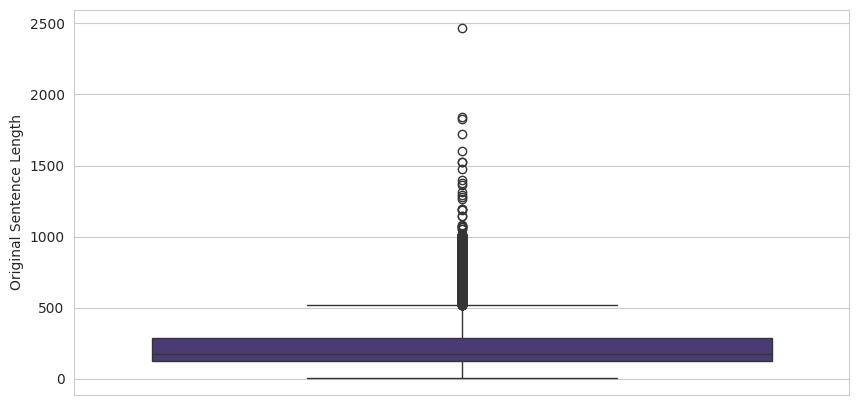

In [181]:
#Let's plot boxplot to see distribution of length

plt.figure(figsize=(10,5))
sns.boxplot(data['Original Sentence Length'])
plt.show()

In [182]:
#Convert words to tokens

max_features=2000
tokenizer=Tokenizer(num_words=max_features, oov_token='<OOV>')
tokenizer.fit_on_texts(data['text'])




In [183]:
word_index=tokenizer.word_index
word_index

{'<OOV>': 1,
 'the': 2,
 'and': 3,
 'a': 4,
 'of': 5,
 'to': 6,
 'is': 7,
 'br': 8,
 'in': 9,
 'it': 10,
 'i': 11,
 'this': 12,
 'that': 13,
 'was': 14,
 'as': 15,
 'for': 16,
 'with': 17,
 'movie': 18,
 'but': 19,
 'film': 20,
 'on': 21,
 'not': 22,
 'you': 23,
 'his': 24,
 'are': 25,
 'have': 26,
 'he': 27,
 'be': 28,
 'one': 29,
 'all': 30,
 'at': 31,
 'by': 32,
 'an': 33,
 'they': 34,
 'who': 35,
 'so': 36,
 'from': 37,
 'like': 38,
 'her': 39,
 'or': 40,
 'just': 41,
 'about': 42,
 "it's": 43,
 'out': 44,
 'has': 45,
 'if': 46,
 'there': 47,
 'some': 48,
 'what': 49,
 'good': 50,
 'more': 51,
 'when': 52,
 'very': 53,
 'up': 54,
 'no': 55,
 'time': 56,
 'even': 57,
 'she': 58,
 'my': 59,
 'would': 60,
 'which': 61,
 'only': 62,
 'story': 63,
 'really': 64,
 'see': 65,
 'their': 66,
 'had': 67,
 'can': 68,
 'were': 69,
 'me': 70,
 'well': 71,
 'than': 72,
 'we': 73,
 'much': 74,
 'been': 75,
 'bad': 76,
 'get': 77,
 'will': 78,
 'also': 79,
 'do': 80,
 'into': 81,
 'other': 82,
 'b

In [184]:
X = tokenizer.texts_to_sequences(data['text'])
X = pad_sequences(X, maxlen=100)

In [185]:
X

array([[  5, 110,   4, ...,   7, 177, 398],
       [133,  88,   1, ...,  15,   4, 485],
       [  4, 112,  13, ...,  66, 527,  71],
       ...,
       [  1,   1,   7, ..., 410,  77,   1],
       [258,   1,   1, ...,   5,   2,   1],
       [ 36,  50,  36, ...,  18,  97,  76]], dtype=int32)

In [186]:
#Use Label Encoder to convert y

le=LabelEncoder()
y=le.fit_transform(data['label'])


In [187]:
y

array([1, 1, 1, ..., 0, 0, 0])

In [188]:
#Use GloVe method

# load the GloVe vectors in a dictionary:

from tqdm import tqdm
import numpy as np

embeddings_index = {}
f = open(r'/content/drive/MyDrive/Colab Notebooks/Projects/NLP/glove.6B.50d.txt',encoding="utf8")

for line in tqdm(f):
    # Splitting the each line
    values = line.split()

    word = values[0]

    coefs = np.array(values[1:], dtype='float32')

    embeddings_index[word] = coefs

f.close()

print('Found %s word vectors.' % len(embeddings_index))

400000it [00:07, 53930.39it/s]

Found 400000 word vectors.


In [189]:
embeddings_index

{'the': array([ 4.1800e-01,  2.4968e-01, -4.1242e-01,  1.2170e-01,  3.4527e-01,
        -4.4457e-02, -4.9688e-01, -1.7862e-01, -6.6023e-04, -6.5660e-01,
         2.7843e-01, -1.4767e-01, -5.5677e-01,  1.4658e-01, -9.5095e-03,
         1.1658e-02,  1.0204e-01, -1.2792e-01, -8.4430e-01, -1.2181e-01,
        -1.6801e-02, -3.3279e-01, -1.5520e-01, -2.3131e-01, -1.9181e-01,
        -1.8823e+00, -7.6746e-01,  9.9051e-02, -4.2125e-01, -1.9526e-01,
         4.0071e+00, -1.8594e-01, -5.2287e-01, -3.1681e-01,  5.9213e-04,
         7.4449e-03,  1.7778e-01, -1.5897e-01,  1.2041e-02, -5.4223e-02,
        -2.9871e-01, -1.5749e-01, -3.4758e-01, -4.5637e-02, -4.4251e-01,
         1.8785e-01,  2.7849e-03, -1.8411e-01, -1.1514e-01, -7.8581e-01],
       dtype=float32),
 ',': array([ 0.013441,  0.23682 , -0.16899 ,  0.40951 ,  0.63812 ,  0.47709 ,
        -0.42852 , -0.55641 , -0.364   , -0.23938 ,  0.13001 , -0.063734,
        -0.39575 , -0.48162 ,  0.23291 ,  0.090201, -0.13324 ,  0.078639,
        -0.4

In [190]:
#Creating embedding_matrix

all_embs = np.stack(list(embeddings_index.values()))
emb_mean,emb_std = all_embs.mean(), all_embs.std()
embed_size = all_embs.shape[1]

word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))
#change below line if computing normal stats is too slow
embedding_matrix = embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

In [191]:
embedding_vector

array([ 0.028701,  0.18203 ,  0.51393 ,  0.30359 ,  0.44307 ,  0.089739,
       -0.93366 ,  0.11061 , -0.52764 , -0.29943 , -0.25354 ,  1.1438  ,
       -1.1905  , -0.73267 , -0.03474 ,  0.10275 ,  0.58505 , -0.51448 ,
       -0.5714  , -0.19427 ,  0.60817 ,  0.38057 ,  0.17012 , -0.21481 ,
       -0.41542 , -0.5551  ,  0.27265 , -0.5036  , -0.99783 , -0.025933,
        1.6702  , -0.59922 ,  1.2308  ,  0.019954,  0.20469 , -0.93934 ,
       -0.50766 , -0.44722 ,  0.88096 , -1.1925  ,  0.052043,  0.14961 ,
       -0.06009 , -0.6437  ,  0.20364 , -0.58504 , -0.2036  , -0.55705 ,
        0.33999 ,  1.0997  ], dtype=float32)

Question-

Model Construction and Training
Construct a suitable model and train the model on the dataset

In [192]:
#Let's create neural network model

model=Sequential()
model.add(Embedding(nb_words, embed_size,weights=[embedding_matrix], input_shape=(X.shape[1],), trainable=True))
model.add(SpatialDropout1D(0.2))
model.add(GlobalAveragePooling1D())
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1,activation='sigmoid'))

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001), loss='binary_crossentropy', metrics=['acc'])

In [193]:
model.summary()

Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_19 (Embedding)        │ (None, 100, 50)        │       100,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_20            │ (None, 100, 50)        │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_4      │ (None, 50)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 64)             │         3,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 103,329 (403.63 KB)

 Trainable params: 103,329 (403.63 KB)

 Non-trainable params: 0 (0.00 B)

In [194]:
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=5)
mcp_save = ModelCheckpoint('.mdl_wts.h5', save_best_only=True, monitor='loss', mode='min')

In [195]:
# specifying the batch size
batch_size = 64

# fitting the model on the training data with 10 epochs
his = model.fit(X, y, epochs = 5, batch_size = batch_size, callbacks=[es,mcp_save], verbose = 'auto')

Epoch 1/5
376/383 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - acc: 0.5626 - loss: 0.6824

383/383 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - acc: 0.5640 - loss: 0.6814
Epoch 2/5
382/383 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - acc: 0.7716 - loss: 0.4808

383/383 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - acc: 0.7717 - loss: 0.4806
Epoch 3/5
383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - acc: 0.8126 - loss: 0.4105

383/383 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - acc: 0.8126 - loss: 0.4104
Epoch 4/5
376/383 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - acc: 0.8346 - loss: 0.3693

383/383 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - acc: 0.8346 - loss: 0.3693
Epoch 5/5
383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - acc: 0.8444 - loss: 0.3516

383/383 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - acc: 0.8444 - loss: 0.3516


In [196]:
#Let me try using LSTM model

model2=Sequential()
model2.add(Embedding(nb_words, embed_size,weights=[embedding_matrix], input_shape=(X.shape[1],), trainable=True))
model2.add(SpatialDropout1D(0.2))
model2.add(Bidirectional(LSTM(64, return_sequences=False)))
model2.add(Dense(1, activation = 'sigmoid'))

model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001), loss='binary_crossentropy', metrics=['acc'])

In [197]:
model2.summary()

Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_20 (Embedding)        │ (None, 100, 50)        │       100,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_21            │ (None, 100, 50)        │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 128)            │        58,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 159,009 (621.13 KB)

 Trainable params: 159,009 (621.13 KB)

 Non-trainable params: 0 (0.00 B)

In [198]:
# specifying the batch size
batch_size = 64

# fitting the model on the training data with 10 epochs
his2 = model2.fit(X, y, epochs = 5, batch_size = batch_size, callbacks=[es,mcp_save], verbose = 'auto')

Epoch 1/5
383/383 ━━━━━━━━━━━━━━━━━━━━ 62s 149ms/step - acc: 0.6148 - loss: 0.6380
Epoch 2/5
383/383 ━━━━━━━━━━━━━━━━━━━━ 81s 148ms/step - acc: 0.7977 - loss: 0.4403
Epoch 3/5
383/383 ━━━━━━━━━━━━━━━━━━━━ 81s 145ms/step - acc: 0.8331 - loss: 0.3761
Epoch 4/5
383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - acc: 0.8500 - loss: 0.3440

383/383 ━━━━━━━━━━━━━━━━━━━━ 83s 149ms/step - acc: 0.8500 - loss: 0.3440
Epoch 5/5
383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - acc: 0.8603 - loss: 0.3166

383/383 ━━━━━━━━━━━━━━━━━━━━ 56s 145ms/step - acc: 0.8603 - loss: 0.3166


In [199]:
#Convert test dataset to tokens
X_test = tokenizer.texts_to_sequences(data_test['text'])
X_test = pad_sequences(X_test, maxlen=100)
y_test = le.transform(data_test['label'])

Question-

This criterion is linked to a Learning OutcomeModel Evaluation
Evaluate the model on data_test.csv and compute the evaluation/accuracy score

In [200]:
model.evaluate(X_test, y_test)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - acc: 0.7765 - loss: 0.4104  


[0.4311279058456421, 0.7769423723220825]

In [201]:
ypred = model.predict(X_test)
ypred_label = [1 if prob >= 0.7 else 0 for prob in ypred]
ypred_label[:5]

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


[0, 1, 0, 1, 1]

In [202]:
print(classification_report(y_test, ypred_label, target_names = ['Not Sarcastic','Sarcastic']))

               precision    recall  f1-score   support

Not Sarcastic       0.74      0.88      0.80       200
    Sarcastic       0.85      0.69      0.76       199

     accuracy                           0.78       399
    macro avg       0.79      0.78      0.78       399
 weighted avg       0.79      0.78      0.78       399



In [203]:
#Evaluate models

model2.evaluate(X_test, y_test)


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - acc: 0.7714 - loss: 0.4332


[0.39548712968826294, 0.8120300769805908]

In [204]:
ypred2 = model2.predict(X_test)

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step


In [205]:
ypred_label2 = [1 if prob >= 0.7 else 0 for prob in ypred2]
ypred_label2[:5]

[0, 1, 0, 1, 1]

In [206]:
print(classification_report(y_test, ypred_label2, target_names = ['Not Sarcastic','Sarcastic']))

               precision    recall  f1-score   support

Not Sarcastic       0.74      0.92      0.82       200
    Sarcastic       0.89      0.67      0.77       199

     accuracy                           0.80       399
    macro avg       0.82      0.80      0.79       399
 weighted avg       0.82      0.80      0.79       399



Conclusion-

I have used CNN and bidirectional LSTM as models. Accuracy is quite impressive in both the cases with accuracy more than 80%. Bidirectional LSTM is better model comparatively.